In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
from scipy.optimize import brentq
import itertools
from tqdm import tqdm

In [10]:
day=0

In [11]:
data_path = './round-3-island-data-bottle'
data_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
price_dfs = [pd.read_csv(os.path.join(data_path, f), delimiter=";") for f in data_files if f.startswith('prices')]
day_price = price_dfs[day]
day_price

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,VOLCANIC_ROCK_VOUCHER_10500,99.0,19.0,NaN,NaN,NaN,NaN,100,19,NaN,NaN,NaN,NaN,99.5,0.0
1,0,0,DJEMBES,13493.0,72.0,NaN,NaN,NaN,NaN,13494,72,NaN,NaN,NaN,NaN,13493.5,0.0
2,0,0,CROISSANTS,4321.0,111.0,NaN,NaN,NaN,NaN,4322,111,NaN,NaN,NaN,NaN,4321.5,0.0
3,0,0,JAMS,6631.0,210.0,NaN,NaN,NaN,NaN,6633,210,NaN,NaN,NaN,NaN,6632.0,0.0
4,0,0,VOLCANIC_ROCK_VOUCHER_10000,505.0,19.0,NaN,NaN,NaN,NaN,506,19,NaN,NaN,NaN,NaN,505.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139995,0,999900,VOLCANIC_ROCK_VOUCHER_10250,277.0,7.0,NaN,NaN,NaN,NaN,278,18,NaN,NaN,NaN,NaN,277.5,0.0
139996,0,999900,JAMS,6541.0,183.0,NaN,NaN,NaN,NaN,6543,183,NaN,NaN,NaN,NaN,6542.0,0.0
139997,0,999900,VOLCANIC_ROCK_VOUCHER_10000,515.0,7.0,NaN,NaN,NaN,NaN,517,18,NaN,NaN,NaN,NaN,516.0,0.0
139998,0,999900,DJEMBES,13409.0,64.0,NaN,NaN,NaN,NaN,13410,64,NaN,NaN,NaN,NaN,13409.5,0.0


In [12]:
day_price['product'].unique()

array(['VOLCANIC_ROCK_VOUCHER_10500', 'DJEMBES', 'CROISSANTS', 'JAMS',
       'VOLCANIC_ROCK_VOUCHER_10000', 'KELP',
       'VOLCANIC_ROCK_VOUCHER_9750', 'PICNIC_BASKET1', 'PICNIC_BASKET2',
       'VOLCANIC_ROCK_VOUCHER_9500', 'RAINFOREST_RESIN',
       'VOLCANIC_ROCK_VOUCHER_10250', 'SQUID_INK', 'VOLCANIC_ROCK'],
      dtype=object)

In [13]:
vol_rock_price = day_price[day_price['product'].str.startswith("VOLCANIC")]
vol_rock_price = pd.pivot(data=vol_rock_price, index='timestamp', columns='product', values='mid_price')
vol_rock_price

product,VOLCANIC_ROCK,VOLCANIC_ROCK_VOUCHER_10000,VOLCANIC_ROCK_VOUCHER_10250,VOLCANIC_ROCK_VOUCHER_10500,VOLCANIC_ROCK_VOUCHER_9500,VOLCANIC_ROCK_VOUCHER_9750
timestamp,,,,,,
0,10503.0,505.5,273.5,99.5,1003.5,754.5
100,10510.0,515.5,279.5,102.5,1010.5,761.5
200,10513.0,516.5,282.5,104.5,1013.5,764.5
300,10517.5,521.5,285.5,106.5,1018.0,768.5
400,10509.5,512.5,279.5,102.5,1010.0,760.5
...,...,...,...,...,...,...
999500,10514.5,515.5,277.5,94.5,1014.5,765.0
999600,10511.5,514.5,275.5,93.5,1012.5,762.5
999700,10513.5,515.5,276.5,93.5,1013.5,763.5


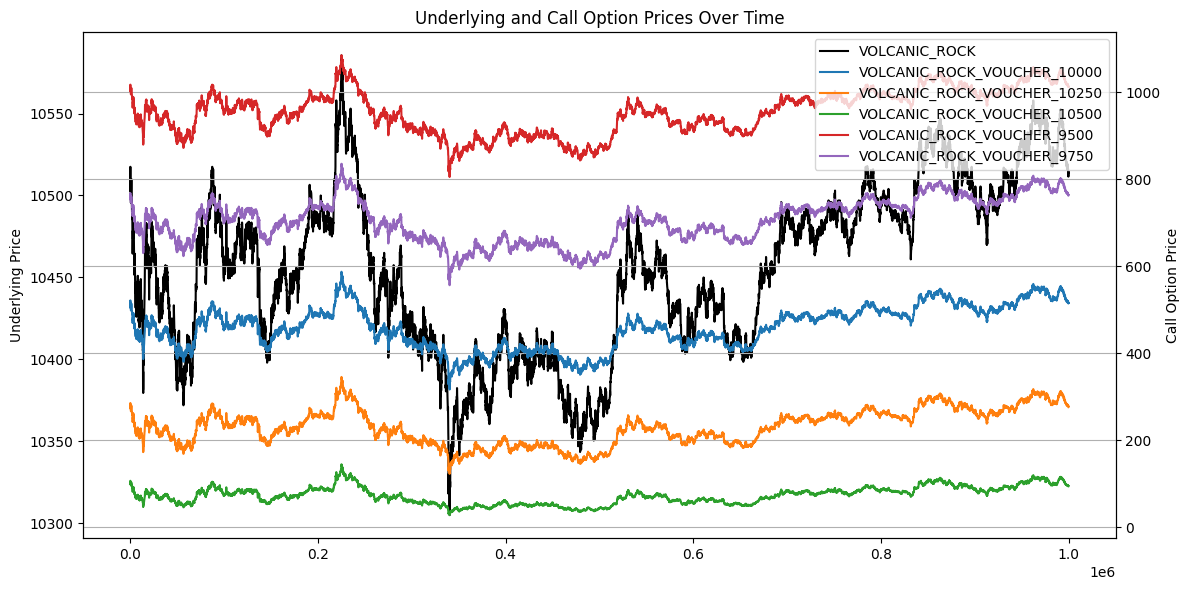

In [14]:
# Identify underlying and option columns
underlying_col = "VOLCANIC_ROCK"
option_cols = [col for col in vol_rock_price.columns if col.startswith("VOLCANIC_ROCK_VOUCHER")]

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot underlying on primary y-axis
ax1.plot(vol_rock_price.index, vol_rock_price[underlying_col], color='black', label=underlying_col)
ax1.set_ylabel("Underlying Price", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create secondary y-axis for option prices
ax2 = ax1.twinx()
for col in option_cols:
    ax2.plot(vol_rock_price.index, vol_rock_price[col], label=col)
ax2.set_ylabel("Call Option Price")
ax2.tick_params(axis='y')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')

# Labels
plt.title("Underlying and Call Option Prices Over Time")
plt.xlabel("Index")
plt.grid(True)
plt.tight_layout()
plt.show()

### Compute IV

In [15]:
# Black-Scholes formula for call
def bs_call_price(S, K, T, sigma):
    d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * norm.cdf(d2)

# Implied volatility solver
def implied_vol(price, S, K, T):
    try:
        return brentq(lambda sigma: bs_call_price(S, K, T, sigma) - price, 1e-6, 5.0)
    except:
        return np.nan


In [16]:

strikes = [9500, 9750, 10000, 10250, 10500]
voucher_cols = [f"VOLCANIC_ROCK_VOUCHER_{k}" for k in strikes]

# Compute time to expiry in years
vol_rock_price['T'] = ((8-day) - (vol_rock_price.index / int(1e7))) / 365 

# Compute implied vol for each strike
for strike, col in zip(strikes, voucher_cols):
    vol_rock_price[f"IV_{strike}"] = [
        implied_vol(price=row[col], S=row['VOLCANIC_ROCK'], K=strike, T=row['T']) 
        for _, row in tqdm(vol_rock_price.iterrows())
    ]

10000it [00:07, 1316.60it/s]
10000it [00:11, 884.05it/s]
10000it [00:12, 817.71it/s]
10000it [00:08, 1147.76it/s]
10000it [00:06, 1457.61it/s]


In [17]:
vol_rock_price

product,VOLCANIC_ROCK,VOLCANIC_ROCK_VOUCHER_10000,VOLCANIC_ROCK_VOUCHER_10250,VOLCANIC_ROCK_VOUCHER_10500,VOLCANIC_ROCK_VOUCHER_9500,VOLCANIC_ROCK_VOUCHER_9750,T,IV_9500,IV_9750,IV_10000,IV_10250,IV_10500
timestamp,,,,,,,,,,,,
0,10503.0,505.5,273.5,99.5,1003.5,754.5,0.021918,0.257403,0.225053,0.169981,0.163139,0.157995
100,10510.0,515.5,279.5,102.5,1010.5,761.5,0.021918,0.258922,0.226785,0.197744,0.163283,0.157017
200,10513.0,516.5,282.5,104.5,1013.5,764.5,0.021918,0.259572,0.227527,0.182783,0.164515,0.157710
300,10517.5,521.5,285.5,106.5,1018.0,768.5,0.021918,0.260547,0.216954,0.188468,0.162067,0.157093
400,10509.5,512.5,279.5,102.5,1010.0,760.5,0.021918,0.258814,0.215056,0.177030,0.164466,0.157437
...,...,...,...,...,...,...,...,...,...,...,...,...
999500,10514.5,515.5,277.5,94.5,1014.5,765.0,0.021644,0.000001,0.200609,0.152221,0.146432,0.141172
999600,10511.5,514.5,275.5,93.5,1012.5,762.5,0.021644,0.281910,0.216889,0.178710,0.148517,0.142120
999700,10513.5,515.5,276.5,93.5,1013.5,763.5,0.021644,0.000001,0.000001,0.167920,0.146048,0.140408


### Plot IV

Strike 9500: 133 NaNs


<Figure size 1200x600 with 0 Axes>

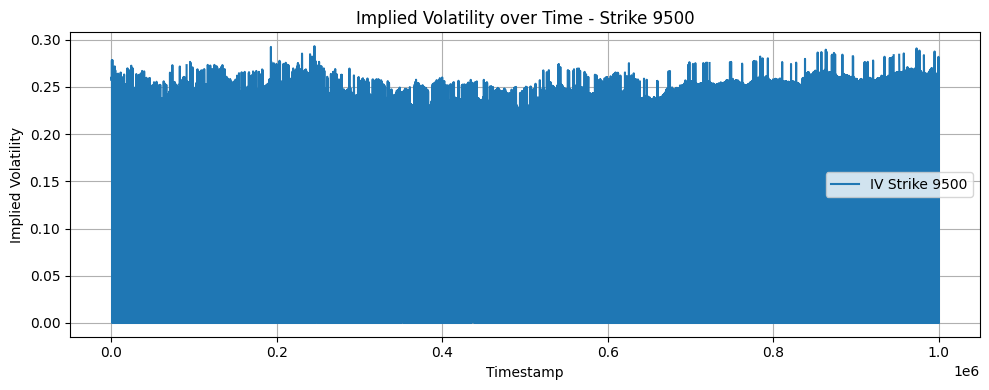

Strike 9750: 27 NaNs


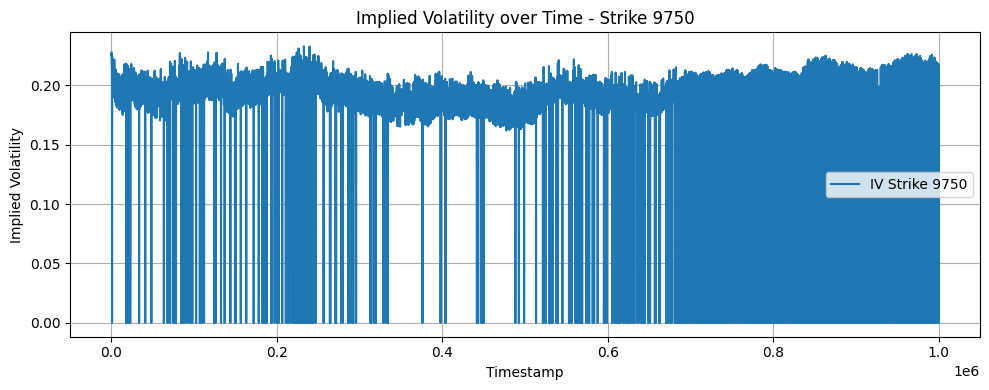

Strike 10000: 0 NaNs


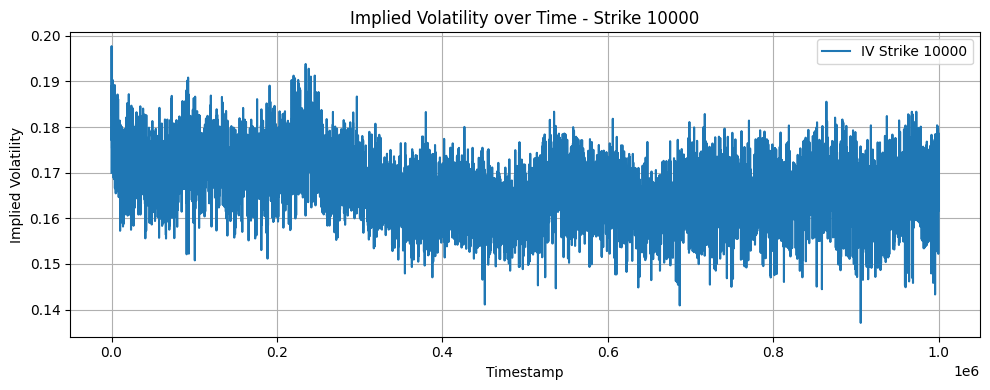

Strike 10250: 0 NaNs


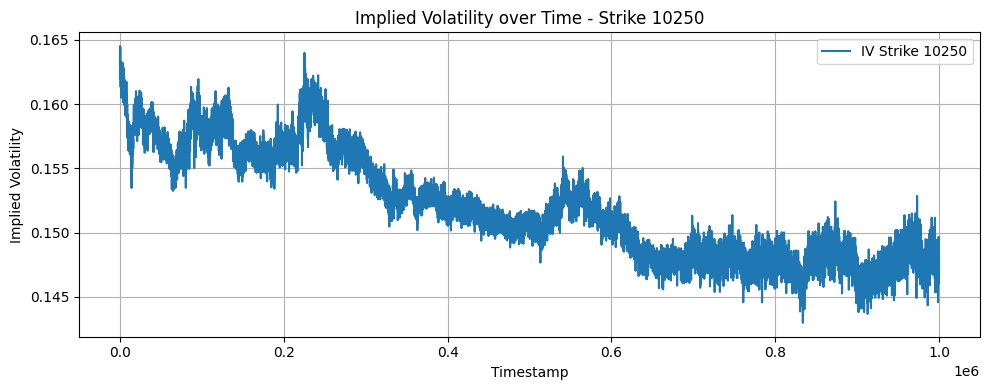

Strike 10500: 0 NaNs


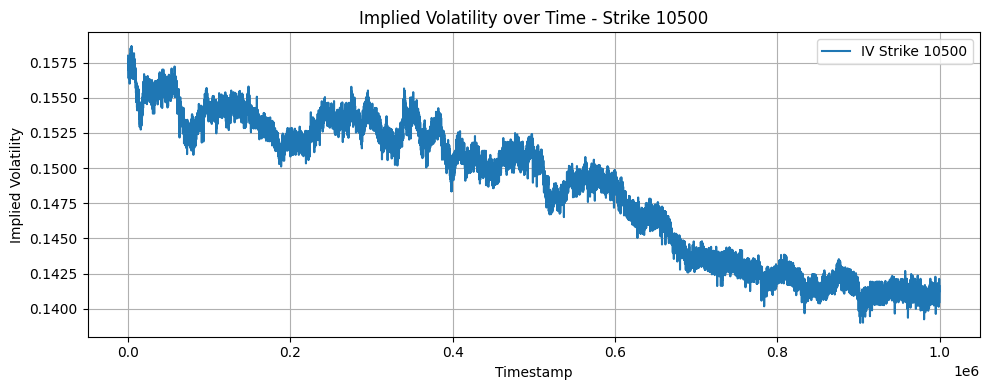

In [18]:
# Set up the plot
plt.figure(figsize=(12, 6))
strikes = [9500, 9750, 10000, 10250, 10500]
for strike in strikes:
    col = f"IV_{strike}"
    
    # Print number of NaNs
    num_nans = vol_rock_price[col].isna().sum()
    print(f"Strike {strike}: {num_nans} NaNs")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(vol_rock_price.index, vol_rock_price[col], label=f"IV Strike {strike}")
    plt.title(f"Implied Volatility over Time - Strike {strike}")
    plt.xlabel("Timestamp")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Check IV first difference autocorr

In [19]:
autocorrs = {}

# For each IV series, compute autocorrelation at lags 1, 2, 3
for strike in [9500, 9750, 10000, 10250, 10500]:
    col = f"IV_{strike}"
    series = vol_rock_price[col].diff().dropna()
    autocorrs[col] = {
        f"lag_{lag}": series.autocorr(lag=lag) for lag in [1, 2, 3]
    }

# Convert to DataFrame for display
iv_autocorr_df = pd.DataFrame(autocorrs).T
iv_autocorr_df.index.name = "Strike"
iv_autocorr_df

,lag_1,lag_2,lag_3
Strike,,,
IV_9500,-0.491120,-0.010384,0.007854
IV_9750,-0.499497,0.004195,-0.008821
IV_10000,-0.499034,0.001862,-0.011158
IV_10250,-0.486671,-0.027255,0.032018
IV_10500,-0.478305,-0.019413,0.008388


In [20]:
iv_cols = [f"IV_{k}" for k in [9500, 9750, 10000, 10250, 10500]]
iv_corr = vol_rock_price[iv_cols].corr()

iv_corr

product,IV_9500,IV_9750,IV_10000,IV_10250,IV_10500
product,,,,,
IV_9500,1.000000,0.371661,0.115710,0.153301,0.152343
IV_9750,0.371661,1.000000,0.157558,0.273146,0.289606
IV_10000,0.115710,0.157558,1.000000,0.499832,0.297353
IV_10250,0.153301,0.273146,0.499832,1.000000,0.877480
IV_10500,0.152343,0.289606,0.297353,0.877480,1.000000


### Monetization from mean-reverting IV

Method 1: Only needs one option

When IV low for a call, e.g. 10250. Buy about int(1/delta) calls and short underlying. Nearly delta neutral in a short time but gives positive vega. 

Method 2: When IV is low, Short butterfly. (Needs a way to measure overall iv, possibly average of all 5 ivs).


### Check arbitrage

In [21]:
# Define strikes and their corresponding columns
strikes = [9500, 9750, 10000, 10250, 10500]
call_cols = {k: f"VOLCANIC_ROCK_VOUCHER_{k}" for k in strikes}

# Generate all valid strike pairs (for monotonicity) and triplets (for convexity)
mono_pairs = list(itertools.combinations(strikes, 2))
conv_triplets = list(itertools.combinations(strikes, 3))


# Iterate through each row
for idx, row in vol_rock_price.iterrows():
    timestamp = idx
    spot = row['VOLCANIC_ROCK']
    
    # Check intrinsic value violations
    intr_viol_lower = [
        (idx, spot, k) for k in strikes
        if row[call_cols[k]] < max(spot - k, 0)
    ]

    intr_viol_upper = [
        (idx, spot, k) for k in strikes
        if row[call_cols[k]] > spot
    ]
    
    # Check monotonicity
    mono_viol = [
        (idx, spot, k1, k2)
        for k1, k2 in mono_pairs
        if row[call_cols[k1]] < row[call_cols[k2]]
    ]
    
    # Check convexity
    conv_viol = []
    for k1, k2, k3 in conv_triplets:
        C1 = row[call_cols[k1]]
        C2 = row[call_cols[k2]]
        C3 = row[call_cols[k3]]
        rhs = ((k3 - k2) / (k3 - k1)) * C1 + ((k2 - k1) / (k3 - k1)) * C3
        if C2 > rhs:
            conv_viol.append((idx, spot, k1, k2, k3))
            
    
    


In [22]:
intr_viol_lower

[(999900, 10514.0, 9500)]

In [23]:
intr_viol_upper

[]

In [24]:
mono_viol

[]

In [25]:
conv_viol

[]

In [27]:
import statistics

roll_list = self.traderObject["rolling_data"][prod]
if len(roll_list) >= 2:
    diff_list = [roll_list[i+1] - roll_list[i] for i in range(len(roll_list)-1)]
    rolling_std = statistics.pstdev(diff_list)  # or stdev

NameError: name 'self' is not defined